# Rule-based controller

**Authors:** Victor Alfred Stimpfling, Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will show how locomotion can be achieved using local coordination rules in the absence of centralized mechanism like coupled CPGs.

Previously, we covered how a centralized network of coupled oscillators (CPGs) can give rise to locomotion. A more decentralized mechanism for insect locomotion has been proposed as an alternative: locomotion can emerge from the application of sensory feedback-based rules that dictate for each leg when to lift, swing, or remain in stance phase (see Walknet described in [Cruse et al, 1998](https://doi.org/10.1016/S0893-6080(98)00067-7) and reviewed in [Schilling et al, 2013](https://doi.org/10.1007/s00422-013-0563-5)). This control approach has been applied to robotic locomotor control ([Schneider et al, 2012](https://doi.org/10.1007/978-3-642-27482-4_24)).

In this tutorial, we will implement a controller based on the first three rules of Walknet, namely:

1. The swing ("return stroke" as described in the Walknet paper) of a leg inhibits the swing of the rostral neighboring leg
2. The start of the stance phase ("power stroke" as described in the Walknet paper) of a leg excites the swing of the rostral contralateral neighboring legs.
3. The completion of the stance phase ("caudal position" as described in the Walknet paper) excites the swing of the caudal and contralateral neighboring legs.

These rules are be summarized in this figure:

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/rule_based_controller/rule_based.png?raw=true" alt="rule_based" width="300"/>

## Preprogrammed steps, refactored
We start by loading the preprogrammed steps as explained in the tutorial *[Controlling locomotion with CPGs](https://neuromechfly.org/tutorials/cpg_controller.html#controlling-leg-stepping-with-cpgs)*. This time, we will use the `PreprogrammedSteps` Python class that encapsulates much of the code implemented in the previous tutorial. See [this section of the rule-based controller tutorial](https://neuromechfly.org//tutorials/rule_based_controller.html#preprogrammed-steps-refactored) for documentation of this class.

In [11]:
from flygym.examples.locomotion import PreprogrammedSteps

We can verify that this works by regenerating the following plot from the CPGs tutorial:

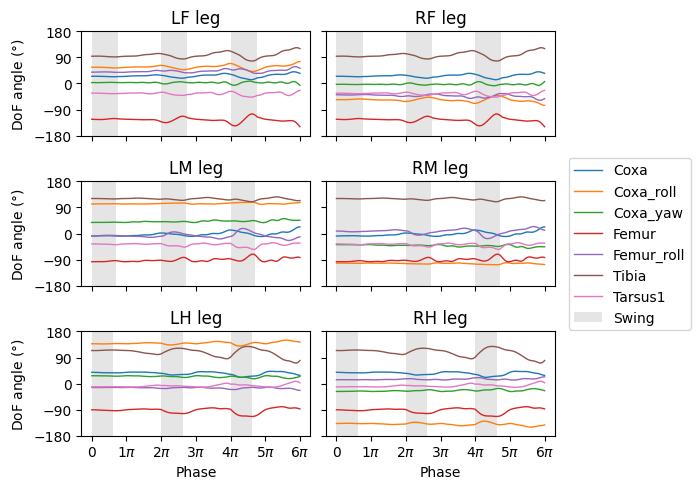

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_dir = Path("./outputs/rule_based_controller")
output_dir.mkdir(parents=True, exist_ok=True)

preprogrammed_steps = PreprogrammedSteps()
theta_ts = np.linspace(0, 3 * 2 * np.pi, 100)
r_ts = np.linspace(0, 1, 100)

fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        joint_angles = preprogrammed_steps.get_joint_angles(leg, theta_ts, r_ts)
        for i_dof, dof_name in enumerate(preprogrammed_steps.dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(
                theta_ts, np.rad2deg(joint_angles[i_dof, :]), linewidth=1, label=legend
            )
        for i_cycle in range(3):
            my_swing_period = preprogrammed_steps.swing_period[leg]
            theta_offset = i_cycle * 2 * np.pi
            ax.axvspan(
                theta_offset + my_swing_period[0],
                theta_offset + my_swing_period[0] + my_swing_period[1],
                color="gray",
                linewidth=0,
                alpha=0.2,
                label="Swing" if i_pos == 0 and i_side == 0 and i_cycle == 0 else None,
            )
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else rf"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig(output_dir / "preprogrammed_steps_class.png")

## Implementing the rules

Next, we implement the first three rules from Walknet. To encode the graph representing the local coordination rules (the first figure of this tutorial), we will construct a `MultiDiGraph` using the Python graph library [NetworkX](https://networkx.org/). This is a convenient way to manipulate a directed graph with multiple edges between the same nodes (in our case, each node represents a leg and each edge represents a coupling rule). Note that this graph representation is not strictly necessary; the user can alternatively implement the same logic using lots of lists and dictionaries in native Python.

In [13]:
import networkx as nx

# For each rule, the keys are the source nodes and the values are the
# target nodes influenced by the source nodes
edges = {
    "rule1": {"LM": ["LF"], "LH": ["LM"], "RM": ["RF"], "RH": ["RM"]},
    "rule2": {
        "LF": ["RF"],
        "LM": ["RM", "LF"],
        "LH": ["RH", "LM"],
        "RF": ["LF"],
        "RM": ["LM", "RF"],
        "RH": ["LH", "RM"],
    },
    "rule3": {
        "LF": ["RF", "LM"],
        "LM": ["RM", "LH"],
        "LH": ["RH"],
        "RF": ["LF", "RM"],
        "RM": ["LM", "RH"],
        "RH": ["LH"],
    },
}

# Construct the rules graph
rules_graph = nx.MultiDiGraph()
for rule_type, d in edges.items():
    for src, tgt_nodes in d.items():
        for tgt in tgt_nodes:
            if rule_type == "rule1":
                rule_type_detailed = rule_type
            else:
                side = "ipsi" if src[0] == tgt[0] else "contra"
                rule_type_detailed = f"{rule_type}_{side}"
            rules_graph.add_edge(src, tgt, rule=rule_type_detailed)

Next, we will implement a helper function that selects the edges given the rule and the source node. This will become handy in the next section.

In [14]:
def filter_edges(graph, rule, src_node=None):
    """Return a list of edges that match the given rule and source node.
    The edges are returned as a list of tuples (src, tgt)."""
    return [
        (src, tgt)
        for src, tgt, rule_type in graph.edges(data="rule")
        if (rule_type == rule) and (src_node is None or src == src_node)
    ]

Using `rules_graph` and the function `filter_edges`, let's visualize connections for each of the three rules. The ipsilateral and contralateral connections of the same rule can have different weights, so let's visualize them separately:

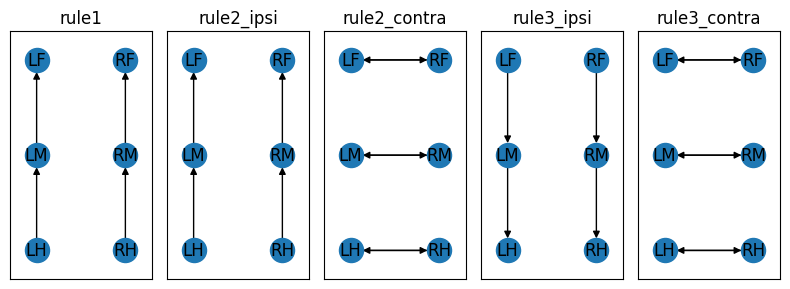

In [15]:
node_pos = {
    "LF": (0, 0),
    "LM": (0, 1),
    "LH": (0, 2),
    "RF": (1, 0),
    "RM": (1, 1),
    "RH": (1, 2),
}
fig, axs = plt.subplots(1, 5, figsize=(8, 3), tight_layout=True)
for i, rule in enumerate(
    ["rule1", "rule2_ipsi", "rule2_contra", "rule3_ipsi", "rule3_contra"]
):
    ax = axs[i]
    selected_edges = filter_edges(rules_graph, rule)
    nx.draw(rules_graph, pos=node_pos, edgelist=selected_edges, with_labels=True, ax=ax)
    ax.set_title(rule)
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.3, 2.3)
    ax.invert_yaxis()
    ax.axis("on")
plt.savefig(output_dir / "rules_graph.png")

Using this rules graph, we will proceed to implement the rule-based leg stepping coordination model. To do this, we will once again construct a Python class.

In the `__init__` method of the class, we will save some metadata and initialize arrays for the contributions to the stepping likelihood scores from each of the three rules. We will also initialize an array to track the current stepping phase — that is, how far into the preprogrammed step the leg is, normalized to [0, 2π]. If a step has completed but a new step has not been initiated, the leg remains at phase 0 indefinitely. To indicate whether the legs are stepping at all, we will create a boolean mask. Finally, we will create two dictionaries to map the leg names to the leg indices and vice versa:

```Python
class RuleBasedSteppingCoordinator:
    legs = ["LF", "LM", "LH", "RF", "RM", "RH"]

    def __init__(
        self, timestep, rules_graph, weights, preprogrammed_steps, margin=0.001, seed=0
    ):
        self.timestep = timestep
        self.rules_graph = rules_graph
        self.weights = weights
        self.preprogrammed_steps = preprogrammed_steps
        self.margin = margin
        self.random_state = np.random.RandomState(seed)
        self._phase_inc_per_step = (
            2 * np.pi * (timestep / self.preprogrammed_steps.duration)
        )
        self.curr_step = 0

        self.rule1_scores = np.zeros(6)
        self.rule2_scores = np.zeros(6)
        self.rule3_scores = np.zeros(6)

        self.leg_phases = np.zeros(6)
        self.mask_is_stepping = np.zeros(6, dtype=bool)

        self._leg2id = {leg: i for i, leg in enumerate(self.legs)}
        self._id2leg = {i: leg for i, leg in enumerate(self.legs)}
```

Let's implement a special `combined_score` method with a `@property` decorator to provide easy access to the sum of all three scores. This way, we can access the total score simply with `stepping_coordinator.combined_score`. Refer to [this tutorial](https://www.programiz.com/python-programming/property) if you want to understand how property methods work in Python.

```Python
    @property
    def combined_scores(self):
        return self.rule1_scores + self.rule2_scores + self.rule3_scores
```

As described in the NeuroMechFly v2 paper, the leg with the highest positive score is stepped. If multiple legs are within a small margin of the highest score, we choose one of these legs at random to avoid bias from numerical artifacts. Let's implement a method that selects the legs that are eligible for stepping:

```Python
    def _get_eligible_legs(self):
        score_thr = self.combined_scores.max()
        score_thr = max(0, score_thr - np.abs(score_thr) * self.margin)
        mask_is_eligible = (
            (self.combined_scores >= score_thr)  # highest or almost highest score
            & (self.combined_scores > 0)  # score is positive
            & ~self.mask_is_stepping  # leg is not currently stepping
        )
        return np.where(mask_is_eligible)[0]
```

Then, let's implement another method that chooses one of the eligible legs at random if at least one leg is eligible, and returns `None` if no leg can be stepped:

```Python
    def _select_stepping_leg(self):
        eligible_legs = self._get_eligible_legs()
        if len(eligible_legs) == 0:
            return None
        return self.random_state.choice(eligible_legs)
```

Now, let's write a method that applies Rule 1 based on the swing mask and the current phases of the legs:

```Python
def _apply_rule1(self):
        for i, leg in enumerate(self.legs):
            is_swinging = (
                0 < self.leg_phases[i] < self.preprogrammed_steps.swing_period[leg][1]
            )
            edges = filter_edges(self.rules_graph, "rule1", src_node=leg)
            for _, tgt in edges:
                self.rule1_scores[self._leg2id[tgt]] = (
                    self.weights["rule1"] if is_swinging else 0
                )
```

Rules 2 and 3 are based on "early" and "late" stance periods (power stroke). We will scale their weights by γ, a ratio indicating how far the leg is into the stance phase. Let's define a helper method that calculates γ:

```Python
    def _get_stance_progress_ratio(self, leg):
        swing_start, swing_end = self.preprogrammed_steps.swing_period[leg]
        stance_duration = 2 * np.pi - swing_end
        curr_stance_progress = self.leg_phases[self._leg2id[leg]] - swing_end
        curr_stance_progress = max(0, curr_stance_progress)
        return curr_stance_progress / stance_duration
```

Now, we can implement Rule 2 and Rule 3:

```Python
    def _apply_rule2(self):
        self.rule2_scores[:] = 0
        for i, leg in enumerate(self.legs):
            stance_progress_ratio = self._get_stance_progress_ratio(leg)
            if stance_progress_ratio == 0:
                continue
            for side in ["ipsi", "contra"]:
                edges = filter_edges(self.rules_graph, f"rule2_{side}", src_node=leg)
                weight = self.weights[f"rule2_{side}"]
                for _, tgt in edges:
                    tgt_id = self._leg2id[tgt]
                    self.rule2_scores[tgt_id] += weight * (1 - stance_progress_ratio)

    def _apply_rule3(self):
        self.rule3_scores[:] = 0
        for i, leg in enumerate(self.legs):
            stance_progress_ratio = self._get_stance_progress_ratio(leg)
            if stance_progress_ratio == 0:
                continue
            for side in ["ipsi", "contra"]:
                edges = filter_edges(self.rules_graph, f"rule3_{side}", src_node=leg)
                weight = self.weights[f"rule3_{side}"]
                for _, tgt in edges:
                    tgt_id = self._leg2id[tgt]
                    self.rule3_scores[tgt_id] += weight * stance_progress_ratio
```

Finally, let's implement the main `step()` method:

```Python
    def step(self):
        if self.curr_step == 0:
            # The first step is always a fore leg or mid leg
            stepping_leg_id = self.random_state.choice([0, 1, 3, 4])
        else:
            stepping_leg_id = self._select_stepping_leg()

        # Initiate a new step, if conditions are met for any leg
        if stepping_leg_id is not None:
            self.mask_is_stepping[stepping_leg_id] = True  # start stepping this leg

        # Progress all stepping legs
        self.leg_phases[self.mask_is_stepping] += self._phase_inc_per_step

        # Check if any stepping legs has completed a step
        mask_has_newly_completed = self.leg_phases >= 2 * np.pi
        self.leg_phases[mask_has_newly_completed] = 0
        self.mask_is_stepping[mask_has_newly_completed] = False

        # Update scores
        self._apply_rule1()
        self._apply_rule2()
        self._apply_rule3()

        self.curr_step += 1
```

This class is actually included in `flygym.examples`. Let's import it.

In [16]:
from flygym.examples.locomotion import RuleBasedController

Let's define the weights of the rules and run 1 second of simulation:

In [17]:
run_time = 1
timestep = 1e-4

weights = {
    "rule1": -10,
    "rule2_ipsi": 2.5,
    "rule2_contra": 1,
    "rule3_ipsi": 3.0,
    "rule3_contra": 2.0,
}

controller = RuleBasedController(
    timestep=timestep,
    rules_graph=rules_graph,
    weights=weights,
    preprogrammed_steps=preprogrammed_steps,
)

score_hist_overall = []
score_hist_rule1 = []
score_hist_rule2 = []
score_hist_rule3 = []
leg_phases_hist = []
for i in range(int(run_time / controller.timestep)):
    controller.step()
    score_hist_overall.append(controller.combined_scores.copy())
    score_hist_rule1.append(controller.rule1_scores.copy())
    score_hist_rule2.append(controller.rule2_scores.copy())
    score_hist_rule3.append(controller.rule3_scores.copy())
    leg_phases_hist.append(controller.leg_phases.copy())

score_hist_overall = np.array(score_hist_overall)
score_hist_rule1 = np.array(score_hist_rule1)
score_hist_rule2 = np.array(score_hist_rule2)
score_hist_rule3 = np.array(score_hist_rule3)
leg_phases_hist = np.array(leg_phases_hist)

Let's also implement a plotting helper function and visualize the leg phases and stepping likelihood scores over time:

In [18]:
def plot_time_series_multi_legs(
    time_series_block,
    timestep,
    spacing=10,
    legs=["LF", "LM", "LH", "RF", "RM", "RH"],
    ax=None,
):
    """Plot a time series of scores for multiple legs.

    Parameters
    ----------
    time_series_block : np.ndarray
        Time series of scores for multiple legs. The shape of the array
        should be (n, m), where n is the number of time steps and m is the
        length of ``legs``.
    timestep : float
        Timestep of the time series in seconds.
    spacing : float, optional
        Spacing between the time series of different legs. Default: 10.
    legs : list[str], optional
        List of leg names. Default: ["LF", "LM", "LH", "RF", "RM", "RH"].
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure and axes will be created.

    Returns
    -------
    matplotlib.axes.Axes
        Axes containing the plot.
    """
    t_grid = np.arange(time_series_block.shape[0]) * timestep
    spacing *= -1
    offset = np.arange(6)[np.newaxis, :] * spacing
    score_hist_viz = time_series_block + offset
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
    for i in range(len(legs)):
        ax.axhline(offset.ravel()[i], color="k", linewidth=0.5)
        ax.plot(t_grid, score_hist_viz[:, i])
    ax.set_yticks(offset[0], legs)
    ax.set_xlabel("Time (s)")
    return ax

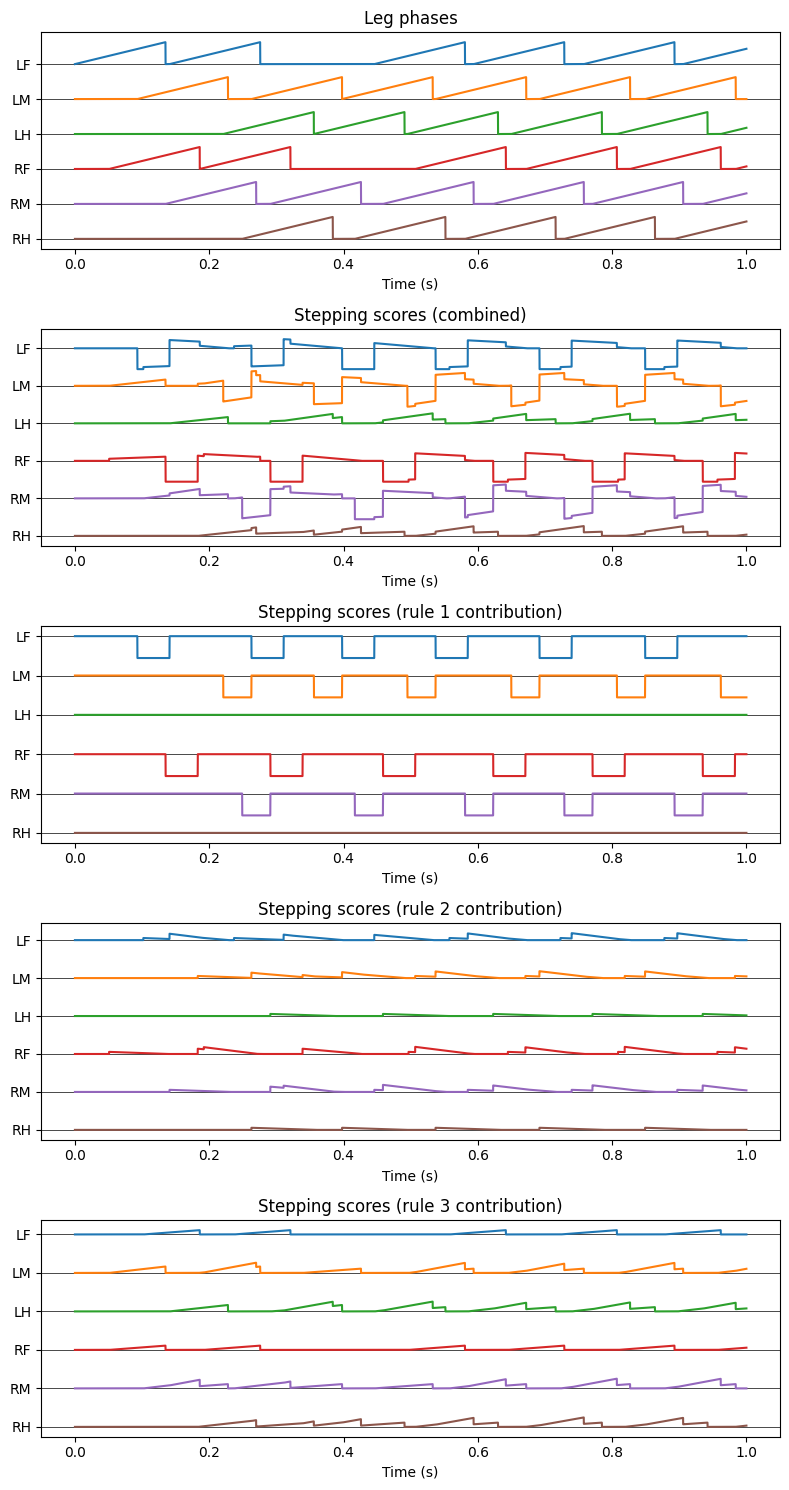

In [19]:
fig, axs = plt.subplots(5, 1, figsize=(8, 15), tight_layout=True)

# Plot leg phases
ax = axs[0]
plot_time_series_multi_legs(leg_phases_hist, timestep=timestep, ax=ax)
ax.set_title("Leg phases")

# Plot combined stepping scores
ax = axs[1]
plot_time_series_multi_legs(score_hist_overall, timestep=timestep, spacing=18, ax=ax)
ax.set_title("Stepping scores (combined)")

# Plot stepping scores (rule 1)
ax = axs[2]
plot_time_series_multi_legs(score_hist_rule1, timestep=timestep, spacing=18, ax=ax)
ax.set_title("Stepping scores (rule 1 contribution)")

# Plot stepping scores (rule 2)
ax = axs[3]
plot_time_series_multi_legs(score_hist_rule2, timestep=timestep, spacing=18, ax=ax)
ax.set_title("Stepping scores (rule 2 contribution)")

# Plot stepping scores (rule 3)
ax = axs[4]
plot_time_series_multi_legs(score_hist_rule3, timestep=timestep, spacing=18, ax=ax)
ax.set_title("Stepping scores (rule 3 contribution)")

fig.savefig(output_dir / "rule_based_control_signals.png")

## Plugging the controller into the simulation

By now, we have:

- implemented the `RuleBasedSteppingCoordinator` that controls the stepping of the legs
- (re)implemented `PreprogrammedSteps` which controls the kinematics of each individual step given the stepping state

The final task is to put everything together and plug the control signals (joint positions) into the NeuroMechFly physics simulation:

In [20]:
from flygym import Fly, ZStabCamera, SingleFlySimulation
from flygym.preprogrammed import all_leg_dofs
from tqdm import trange


controller = RuleBasedController(
    timestep=timestep,
    rules_graph=rules_graph,
    weights=weights,
    preprogrammed_steps=preprogrammed_steps,
)

fly = Fly(
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    draw_adhesion=True,
)

cam = ZStabCamera(
        attachment_point=fly.model.worldbody,
        camera_name="camera_left", attachment_name=fly.name,
        targeted_flies_id=[0], play_speed=0.1
        )

sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    timestep=timestep,
)

obs, info = sim.reset()
for i in trange(int(run_time / sim.timestep)):
    controller.step()
    joint_angles = []
    adhesion_onoff = []
    for leg, phase in zip(controller.legs, controller.leg_phases):
        joint_angles_arr = preprogrammed_steps.get_joint_angles(leg, phase)
        joint_angles.append(joint_angles_arr.flatten())
        adhesion_onoff.append(preprogrammed_steps.get_adhesion_onoff(leg, phase))
    action = {
        "joints": np.concatenate(joint_angles),
        "adhesion": np.array(adhesion_onoff),
    }
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

100%|██████████| 10000/10000 [00:25<00:00, 395.53it/s]


Let's take a look at the result:

In [21]:
cam.save_video(output_dir / "rule_based_controller.mp4")